<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Arch" data-toc-modified-id="Arch-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Arch</a></span></li><li><span><a href="#Embedding-dim" data-toc-modified-id="Embedding-dim-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Embedding dim</a></span></li><li><span><a href="#Cat-embedding-dim" data-toc-modified-id="Cat-embedding-dim-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Cat embedding dim</a></span></li><li><span><a href="#Num-observations" data-toc-modified-id="Num-observations-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Num observations</a></span></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

sns.set_style("whitegrid", {'axes.grid' : False})

from tqdm.auto import tqdm

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
torch.cuda.is_available()

True

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [5]:
from pytorch_metric_learning import losses, miners, distances, reducers, samplers
import torch.optim as optim
from sklearn.model_selection import train_test_split
import torch.nn as nn
import random
import lightgbm as lgb

In [6]:
from code.dataloader import AgeGroupMLDataset, AgeGroupClfDataset
from code.encoder_gru import Encoder
from code.decoder import Decoder
from code.classifier import Classifier
from code.utils import train_ml_model, train_classifier

In [7]:
BATCH_SIZE = 64 # BATCH_SIZE unique persons
NUM_OF_SUBSEQUENCES = 5
SUBSEQUENCE_LENGTH = 90

EMBEDDING_DIM = 256
LR = 0.002
NUM_EPOCHS = 50

cat_vocab_sizes = [204]
cat_embedding_dim = 102
num_input_dim = 4
NUM_OBS = 30000

In [8]:
arches = (
    ('GRU', nn.GRU(
                num_input_dim + cat_embedding_dim,
                EMBEDDING_DIM,
                batch_first=False),
    ),
    ('LSTM', nn.LSTM(
                num_input_dim + cat_embedding_dim,
                EMBEDDING_DIM,
                batch_first=False),
    ),
)

In [9]:
dataset = AgeGroupMLDataset(num_observations=NUM_OBS)

In [10]:
dataset.load_client_to_indices()

In [11]:
clfdataset = AgeGroupClfDataset()

In [12]:
clfdataset.load_client_to_indices()

In [13]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [14]:
targets = dataset.targets

dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE,
    num_workers=0,
)

targets = clfdataset.targets

train_idx, test_idx= train_test_split(
    np.arange(len(targets)),
    test_size=0.3,
    shuffle=True,
    stratify=targets,
    random_state=228
)

train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
test_sampler = torch.utils.data.SubsetRandomSampler(test_idx)

trainloader = torch.utils.data.DataLoader(
    clfdataset, batch_size=BATCH_SIZE,
    sampler=train_sampler)
testloader = torch.utils.data.DataLoader(
    clfdataset, batch_size=BATCH_SIZE,
    sampler=test_sampler)

## Arch

In [ ]:
for (arch, cell) in tqdm(arches):
    print(arch)
    LR = 0.002
    
    # train decoder
    
    encoder = Encoder(
        numerical_input_dim=num_input_dim,
        cat_vocab_sizes=cat_vocab_sizes,
        cat_embedding_dim=cat_embedding_dim,
        embedding_dim=EMBEDDING_DIM,
    )
    encoder.sequence_encoder = cell
    encoder.to(device);
    optimizer = optim.Adam(encoder.parameters(), lr=LR)
    
    distance = distances.CosineSimilarity()
    reducer = reducers.ThresholdReducer(low = 0) # basically, returns average
    loss_func = losses.TripletMarginLoss(margin = 0.4, distance = distance, reducer = reducer)
    mining_func = miners.TripletMarginMiner(margin = 0.4, distance = distance, type_of_triplets = "semihard")
    
    train_losses = train_ml_model(
        encoder, NUM_EPOCHS, dataloader, NUM_OF_SUBSEQUENCES,
        mining_func, loss_func, optimizer)
    fig, axs = plt.subplots(figsize=(12, 6))

    plt.plot(train_losses, label='train')
    plt.xlabel('iter')
    plt.ylabel('loss');
    plt.savefig(f'plots/ML_{arch}_{EMBEDDING_DIM}_{NUM_OBS}_{NUM_EPOCHS}.png')
    
    SCHEDULER_EPOCHS = 2
    LR = 0.002
    
    # train classifier decoder
    
    classifier = Classifier(
        numerical_input_dim=num_input_dim,
        cat_vocab_sizes=cat_vocab_sizes,
        cat_embedding_dim=cat_embedding_dim,
        embedding_dim=EMBEDDING_DIM
    )
    classifier.encoder = encoder
    classifier.freeze_encoder()
    classifier.to(device);
    
    optimizer = optim.Adam(classifier.decoder.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        patience=SCHEDULER_EPOCHS,
    )
    
    train_losses, train_accuracy, val_losses, val_accuracy = train_classifier(
        classifier, NUM_EPOCHS, trainloader, testloader,
        optimizer, criterion, scheduler,
        enable_train_mode = lambda: classifier.decoder.train(),
        enable_test_mode = lambda: classifier.decoder.eval(),
    )
    
    fig, axs = plt.subplots(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='validation')
    plt.xlabel('iter')
    plt.ylabel('loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.xlabel('iter')
    plt.ylabel('accuracy');
    plt.plot(train_accuracy, label='train')
    plt.plot(val_accuracy, label='validation')
    plt.legend()

    plt.savefig(f'plots/clfdec_{arch}_{EMBEDDING_DIM}_{NUM_OBS}_{NUM_EPOCHS}.png')

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache() 

## Embedding dim

In [ ]:
arch = 'GRU'

dims = [32, 64, 128, 256, 512, 1024]
accs = []

for EMBEDDING_DIM in tqdm(dims):
    print(EMBEDDING_DIM)
    LR = 0.002
    
    # train decoder
    
    encoder = Encoder(
        numerical_input_dim=num_input_dim,
        cat_vocab_sizes=cat_vocab_sizes,
        cat_embedding_dim=cat_embedding_dim,
        embedding_dim=EMBEDDING_DIM,
    )
    encoder.to(device);
    encoder.train()
    optimizer = optim.Adam(encoder.parameters(), lr=LR)
    
    distance = distances.CosineSimilarity()
    reducer = reducers.ThresholdReducer(low = 0) # basically, returns average
    loss_func = losses.TripletMarginLoss(margin = 0.4, distance = distance, reducer = reducer)
    mining_func = miners.TripletMarginMiner(margin = 0.4, distance = distance, type_of_triplets = "semihard")
    
    train_losses = train_ml_model(
        encoder, NUM_EPOCHS, dataloader, NUM_OF_SUBSEQUENCES,
        mining_func, loss_func, optimizer)
    fig, axs = plt.subplots(figsize=(12, 6))

    plt.plot(train_losses, label='train')
    plt.xlabel('iter')
    plt.ylabel('loss');
    plt.savefig(f'plots/ML_{arch}_{EMBEDDING_DIM}_{NUM_OBS}_{NUM_EPOCHS}.png')
    
    SCHEDULER_EPOCHS = 2
    LR = 0.002
    
    # train classifier decoder
    
    classifier = Classifier(
        numerical_input_dim=num_input_dim,
        cat_vocab_sizes=cat_vocab_sizes,
        cat_embedding_dim=cat_embedding_dim,
        embedding_dim=EMBEDDING_DIM
    )
    classifier.encoder = encoder
    classifier.freeze_encoder()
    classifier.to(device);
    
    optimizer = optim.Adam(classifier.decoder.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        patience=SCHEDULER_EPOCHS,
    )
    
    train_losses, train_accuracy, val_losses, val_accuracy = train_classifier(
        classifier, NUM_EPOCHS, trainloader, testloader,
        optimizer, criterion, scheduler,
        enable_train_mode = lambda: classifier.decoder.train(),
        enable_test_mode = lambda: classifier.decoder.eval(),
    )
    
    fig, axs = plt.subplots(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='validation')
    plt.xlabel('iter')
    plt.ylabel('loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.xlabel('iter')
    plt.ylabel('accuracy');
    plt.plot(train_accuracy, label='train')
    plt.plot(val_accuracy, label='validation')
    plt.legend()

    plt.savefig(f'plots/clfdec_{arch}_{EMBEDDING_DIM}_{NUM_OBS}_{NUM_EPOCHS}.png')
    
    accs.append(val_accuracy[-1])

In [ ]:
plt.plot(dims, accs)
plt.xlabel('Embedding dimension')
plt.ylabel('accuracy');
plt.savefig(f'plots/clfdec_{arch}_embedding_to_acc_{NUM_OBS}_{NUM_EPOCHS}.png')

## Cat embedding dim

  0%|          | 0/5 [00:00<?, ?it/s]

20


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0 Loss = 0.19061031937599182
Epoch 1 Loss = 0.16281573474407196
Epoch 2 Loss = 0.15350551903247833
Epoch 3 Loss = 0.14904651045799255
Epoch 4 Loss = 0.14590305089950562
Epoch 5 Loss = 0.1444436013698578
Epoch 6 Loss = 0.14322969317436218
Epoch 7 Loss = 0.1425512135028839
Epoch 8 Loss = 0.14188100397586823
Epoch 9 Loss = 0.1410197913646698
Epoch 10 Loss = 0.14037282764911652
Epoch 11 Loss = 0.13998658955097198
Epoch 12 Loss = 0.13985823094844818
Epoch 13 Loss = 0.1393664926290512
Epoch 14 Loss = 0.13886144757270813
Epoch 15 Loss = 0.13862402737140656
Epoch 16 Loss = 0.13830865919589996
Epoch 17 Loss = 0.1379707157611847
Epoch 18 Loss = 0.13780543208122253
Epoch 19 Loss = 0.13775400817394257


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, train acc: 0.5244285464286804, val acc: 0.5484444499015808
train loss: 1.06912362575531; val loss: 1.0031089782714844
Epoch 1, train acc: 0.5454285740852356, val acc: 0.5583333373069763
train loss: 1.0048141479492188; val loss: 0.9837539196014404
Epoch 2, train acc: 0.5511904954910278, val acc: 0.5492222309112549
train loss: 1.0003396272659302; val loss: 0.986864447593689
Epoch 3, train acc: 0.5497142672538757, val acc: 0.5625555515289307
train loss: 1.0014069080352783; val loss: 0.980681836605072
Epoch 4, train acc: 0.5522381067276001, val acc: 0.5432222485542297
train loss: 0.9974005222320557; val loss: 0.995322048664093
Epoch 5, train acc: 0.5543333292007446, val acc: 0.5522222518920898
train loss: 0.9933011531829834; val loss: 0.9922640919685364
Epoch 6, train acc: 0.5524285435676575, val acc: 0.5645555853843689
train loss: 0.9914657473564148; val loss: 0.9799356460571289
Epoch 7, train acc: 0.5519999861717224, val acc: 0.5631111264228821
train loss: 0.9968308806419373; va

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0 Loss = 0.182856023311615
Epoch 1 Loss = 0.154827281832695
Epoch 2 Loss = 0.14833518862724304
Epoch 3 Loss = 0.14592739939689636
Epoch 4 Loss = 0.1443568915128708
Epoch 5 Loss = 0.14313986897468567
Epoch 6 Loss = 0.14195629954338074
Epoch 7 Loss = 0.14164425432682037
Epoch 8 Loss = 0.1406746804714203
Epoch 9 Loss = 0.1401522159576416
Epoch 10 Loss = 0.1396683305501938
Epoch 11 Loss = 0.13932746648788452
Epoch 12 Loss = 0.1390213668346405
Epoch 13 Loss = 0.13857759535312653
Epoch 14 Loss = 0.13837066292762756
Epoch 15 Loss = 0.13804516196250916
Epoch 16 Loss = 0.13799354434013367
Epoch 17 Loss = 0.1376289427280426
Epoch 18 Loss = 0.13749390840530396
Epoch 19 Loss = 0.13722893595695496


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, train acc: 0.5336666703224182, val acc: 0.5497778058052063
train loss: 1.0498194694519043; val loss: 0.9985958933830261
Epoch 1, train acc: 0.5518571138381958, val acc: 0.5515555739402771
train loss: 1.0057426691055298; val loss: 0.9953227043151855
Epoch 2, train acc: 0.5515714287757874, val acc: 0.5581111311912537
train loss: 0.9969662427902222; val loss: 0.9836819767951965
Epoch 3, train acc: 0.5487619042396545, val acc: 0.5568888783454895
train loss: 1.0010031461715698; val loss: 0.9873107671737671
Epoch 4, train acc: 0.5549523830413818, val acc: 0.56122225522995
train loss: 0.9938216209411621; val loss: 0.9806652665138245
Epoch 5, train acc: 0.5482380986213684, val acc: 0.5569999814033508
train loss: 0.9926676154136658; val loss: 0.9788426756858826
Epoch 6, train acc: 0.5511904954910278, val acc: 0.5621111392974854
train loss: 0.9997318387031555; val loss: 0.9750433564186096
Epoch 7, train acc: 0.5500476360321045, val acc: 0.5561110973358154
train loss: 0.990768551826477; 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0 Loss = 0.1830088198184967
Epoch 1 Loss = 0.15244150161743164
Epoch 2 Loss = 0.14725595712661743
Epoch 3 Loss = 0.14528492093086243
Epoch 4 Loss = 0.14399421215057373
Epoch 5 Loss = 0.14289283752441406
Epoch 6 Loss = 0.1415812224149704
Epoch 7 Loss = 0.14120395481586456
Epoch 8 Loss = 0.14071404933929443
Epoch 9 Loss = 0.13999082148075104
Epoch 10 Loss = 0.13986453413963318
Epoch 11 Loss = 0.13937769830226898
Epoch 12 Loss = 0.13872042298316956
Epoch 13 Loss = 0.13837385177612305
Epoch 14 Loss = 0.13806168735027313
Epoch 15 Loss = 0.13821257650852203
Epoch 16 Loss = 0.13748236000537872
Epoch 17 Loss = 0.13753336668014526
Epoch 18 Loss = 0.1373620629310608
Epoch 19 Loss = 0.13743875920772552


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, train acc: 0.5237619280815125, val acc: 0.5415555834770203
train loss: 1.0487580299377441; val loss: 1.0110599994659424
Epoch 1, train acc: 0.5464761853218079, val acc: 0.5527777671813965
train loss: 1.007460355758667; val loss: 0.9887351393699646
Epoch 2, train acc: 0.5488571524620056, val acc: 0.5528888702392578
train loss: 1.001131534576416; val loss: 0.9871184229850769
Epoch 3, train acc: 0.552047610282898, val acc: 0.5536666512489319
train loss: 1.000024437904358; val loss: 0.985456109046936
Epoch 4, train acc: 0.5509523749351501, val acc: 0.5490000247955322
train loss: 0.993036150932312; val loss: 0.9867053627967834
Epoch 5, train acc: 0.5484285950660706, val acc: 0.5580000281333923
train loss: 0.9961617588996887; val loss: 0.9802093505859375
Epoch 6, train acc: 0.5524285435676575, val acc: 0.5543333292007446
train loss: 0.992083728313446; val loss: 0.9798382520675659
Epoch 7, train acc: 0.55009526014328, val acc: 0.5561110973358154
train loss: 0.995590090751648; val los

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0 Loss = 0.1776556521654129
Epoch 1 Loss = 0.15117740631103516
Epoch 2 Loss = 0.14658448100090027
Epoch 3 Loss = 0.1447535902261734
Epoch 4 Loss = 0.14357857406139374
Epoch 5 Loss = 0.14266259968280792
Epoch 6 Loss = 0.1416027694940567
Epoch 7 Loss = 0.14094440639019012
Epoch 8 Loss = 0.14041177928447723
Epoch 9 Loss = 0.1400965452194214
Epoch 10 Loss = 0.13973869383335114
Epoch 11 Loss = 0.1391541063785553
Epoch 12 Loss = 0.13900764286518097
Epoch 13 Loss = 0.13841445744037628
Epoch 14 Loss = 0.13825930655002594
Epoch 15 Loss = 0.13801345229148865
Epoch 16 Loss = 0.13747796416282654
Epoch 17 Loss = 0.13764968514442444
Epoch 18 Loss = 0.13736401498317719
Epoch 19 Loss = 0.13715876638889313


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, train acc: 0.5279523730278015, val acc: 0.55522221326828
train loss: 1.0602152347564697; val loss: 0.9926096796989441
Epoch 1, train acc: 0.5492857098579407, val acc: 0.5605555772781372
train loss: 1.0038270950317383; val loss: 0.9887169599533081
Epoch 2, train acc: 0.5488095283508301, val acc: 0.55522221326828
train loss: 1.0007908344268799; val loss: 0.9820510149002075
Epoch 3, train acc: 0.5475237965583801, val acc: 0.5557777881622314
train loss: 1.0029345750808716; val loss: 0.982379138469696
Epoch 4, train acc: 0.5508571267127991, val acc: 0.558222234249115
train loss: 0.995476245880127; val loss: 0.9815656542778015
Epoch 5, train acc: 0.5569999814033508, val acc: 0.5590000152587891
train loss: 0.9886204600334167; val loss: 0.976738691329956
Epoch 6, train acc: 0.5561428666114807, val acc: 0.5574444532394409
train loss: 0.9914882183074951; val loss: 0.9785876870155334
Epoch 7, train acc: 0.5587142705917358, val acc: 0.5594444274902344
train loss: 0.9816201329231262; val l

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0 Loss = 0.17779472470283508
Epoch 1 Loss = 0.1505659967660904
Epoch 2 Loss = 0.14617691934108734
Epoch 3 Loss = 0.1444406509399414
Epoch 4 Loss = 0.14329199492931366
Epoch 5 Loss = 0.14256341755390167
Epoch 6 Loss = 0.1414993554353714
Epoch 7 Loss = 0.14085753262043
Epoch 8 Loss = 0.14028692245483398
Epoch 9 Loss = 0.14007535576820374
Epoch 10 Loss = 0.13950014114379883
Epoch 11 Loss = 0.13944123685359955
Epoch 12 Loss = 0.13862638175487518
Epoch 13 Loss = 0.13831670582294464
Epoch 14 Loss = 0.13809263706207275
Epoch 15 Loss = 0.13781170547008514
Epoch 16 Loss = 0.1376625895500183
Epoch 17 Loss = 0.13751499354839325
Epoch 18 Loss = 0.1372925043106079
Epoch 19 Loss = 0.13704147934913635


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, train acc: 0.5310476422309875, val acc: 0.5528888702392578
train loss: 1.0415050983428955; val loss: 0.9914029240608215
Epoch 1, train acc: 0.5440952181816101, val acc: 0.5518888831138611
train loss: 1.0078195333480835; val loss: 0.9880887269973755
Epoch 2, train acc: 0.5460476279258728, val acc: 0.5551111102104187
train loss: 1.0030800104141235; val loss: 0.9898781180381775
Epoch 3, train acc: 0.5520952343940735, val acc: 0.5531111359596252
train loss: 0.9941627979278564; val loss: 0.9837616086006165
Epoch 4, train acc: 0.5549523830413818, val acc: 0.5568888783454895
train loss: 0.9928340911865234; val loss: 0.9757506251335144
Epoch 5, train acc: 0.5514285564422607, val acc: 0.5602222084999084
train loss: 0.9923126101493835; val loss: 0.9762893319129944
Epoch 6, train acc: 0.555142879486084, val acc: 0.5505555868148804
train loss: 0.991766095161438; val loss: 0.9917008280754089
Epoch 7, train acc: 0.5565237998962402, val acc: 0.5516666769981384
train loss: 0.9891244173049927;

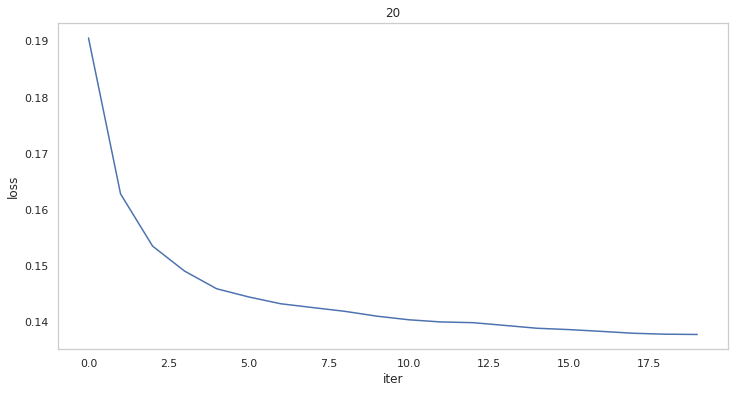

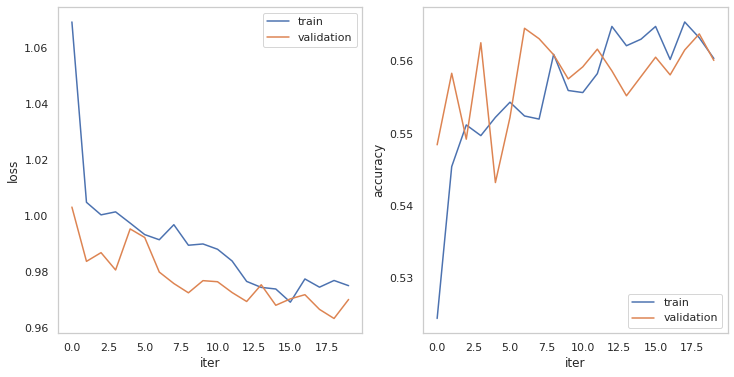

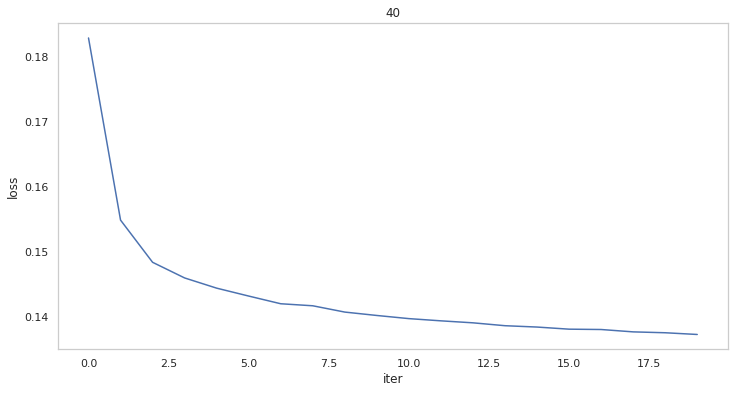

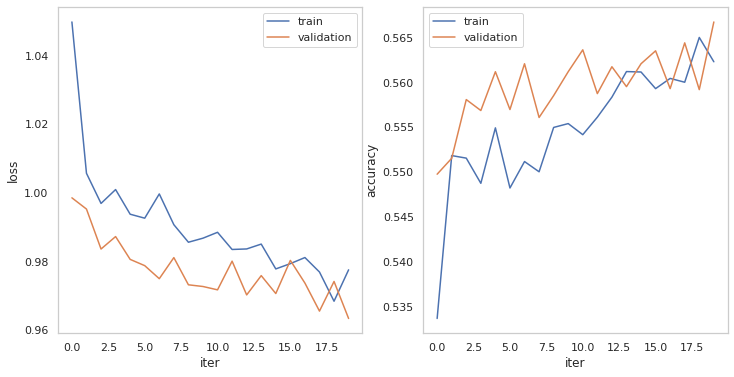

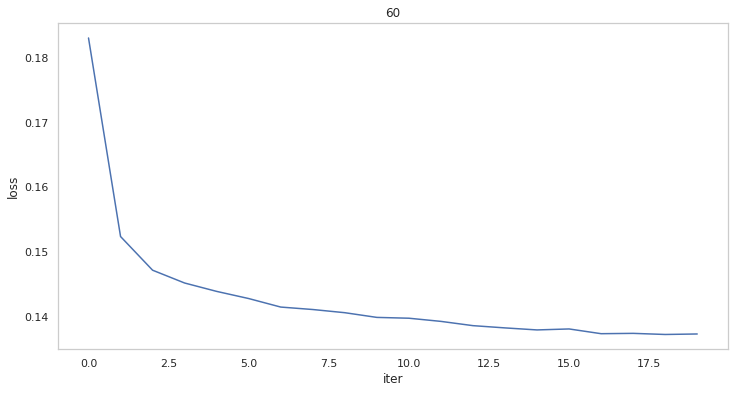

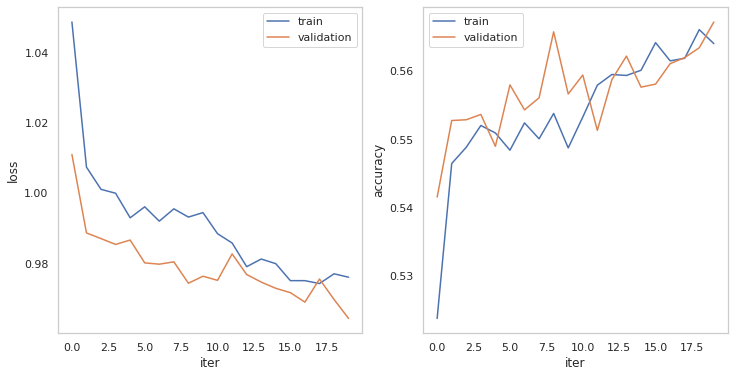

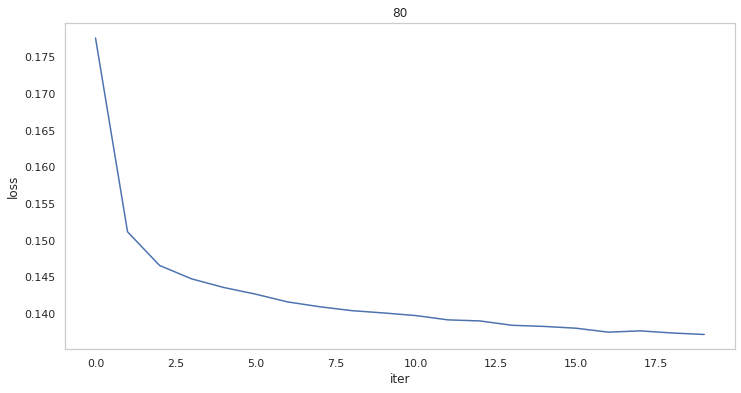

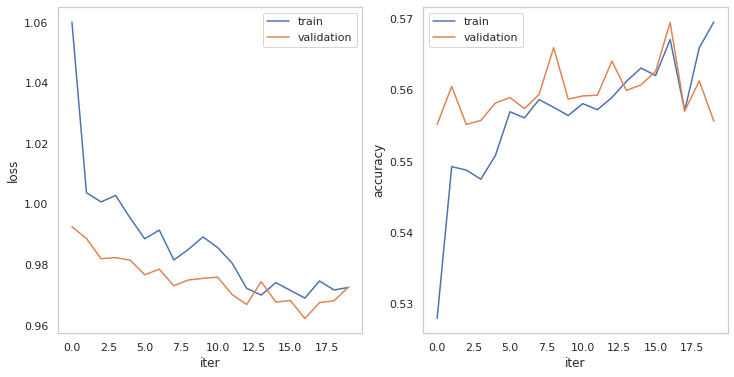

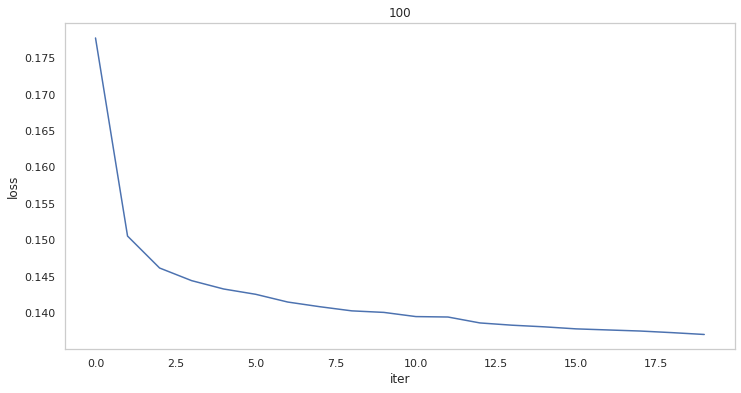

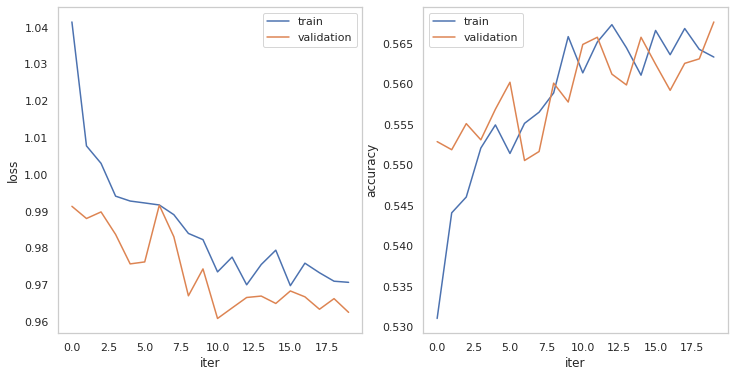

In [16]:
arch = 'GRU'

EMBEDDING_DIM = 256
NUM_EPOCHS=20
dims = [20, 40, 60, 80, 100]
accs = []

for cat_embedding_dim in tqdm(dims):
    print(cat_embedding_dim)
    LR = 0.002
    
    # train decoder
    
    encoder = Encoder(
        numerical_input_dim=num_input_dim,
        cat_vocab_sizes=cat_vocab_sizes,
        cat_embedding_dim=cat_embedding_dim,
        embedding_dim=EMBEDDING_DIM,
    )
    encoder.to(device);
    encoder.train()
    optimizer = optim.Adam(encoder.parameters(), lr=LR)
    
    distance = distances.CosineSimilarity()
    reducer = reducers.ThresholdReducer(low = 0) # basically, returns average
    loss_func = losses.TripletMarginLoss(margin = 0.4, distance = distance, reducer = reducer)
    mining_func = miners.TripletMarginMiner(margin = 0.4, distance = distance, type_of_triplets = "semihard")
    
    train_losses = train_ml_model(
        encoder, NUM_EPOCHS, dataloader, NUM_OF_SUBSEQUENCES,
        mining_func, loss_func, optimizer)
    fig, axs = plt.subplots(figsize=(12, 6))

    plt.plot(train_losses, label='train')
    plt.xlabel('iter')
    plt.ylabel('loss');
    plt.title(f'{cat_embedding_dim}')
    
    SCHEDULER_EPOCHS = 2
    LR = 0.002
    
    # train classifier decoder
    
    classifier = Classifier(
        numerical_input_dim=num_input_dim,
        cat_vocab_sizes=cat_vocab_sizes,
        cat_embedding_dim=cat_embedding_dim,
        embedding_dim=EMBEDDING_DIM
    )
    classifier.encoder = encoder
    classifier.freeze_encoder()
    classifier.to(device);
    
    optimizer = optim.Adam(classifier.decoder.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        patience=SCHEDULER_EPOCHS,
    )
    
    train_losses, train_accuracy, val_losses, val_accuracy = train_classifier(
        classifier, NUM_EPOCHS, trainloader, testloader,
        optimizer, criterion, scheduler,
        enable_train_mode = lambda: classifier.decoder.train(),
        enable_test_mode = lambda: classifier.decoder.eval(),
    )
    
    fig, axs = plt.subplots(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='validation')
    plt.xlabel('iter')
    plt.ylabel('loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.xlabel('iter')
    plt.ylabel('accuracy');
    plt.plot(train_accuracy, label='train')
    plt.plot(val_accuracy, label='validation')
    plt.legend()
    
    accs.append(val_accuracy[-1])

In [20]:
accs = [
    0.5601111054420471,
    0.566777765750885,
    0.5672222375869751,
    0.5676666851043701,
    0.5676666498184204
]

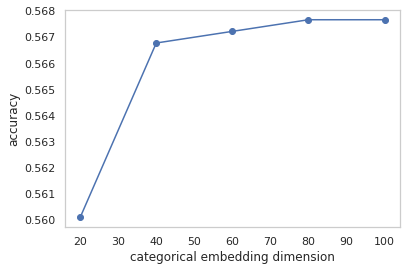

In [28]:
fig, axs = plt.subplots(figsize=(6, 4))
plt.plot(dims, accs)
plt.scatter(dims, accs)
plt.xlabel('categorical embedding dimension')
plt.ylabel('accuracy');
plt.savefig(
    f'plots/clfdec_{arch}_cat_embedding_to_acc_{NUM_OBS}_{NUM_EPOCHS}.png',
    bbox_inches = "tight",
)
# fig.tight_layout()

In [ ]:
dataset = AgeGroupMLDataset()
dataset.load_client_to_indices()
clfdataset = AgeGroupClfDataset()
clfdataset.load_client_to_indices()

## Num observations

In [ ]:
arch = 'GRU'

EMBEDDING_DIM = 256
nums_epochs = [300, 200, 200, 100, 100, 75, 50]
nums_obs = [300, 600, 1300, 2700, 5400, 10800, 21600]
nums_epochs = nums_epochs[::-1]
nums_obs = nums_obs[::-1]
accs = []

for NUM_OBS, NUM_EPOCHS in tqdm(zip(nums_obs, nums_epochs)):
    import gc
    gc.collect()
    torch.cuda.empty_cache()
    print(NUM_OBS, NUM_EPOCHS)
    
    dataset.targets = dataset.targets[:NUM_OBS]
    clfdataset.targets = clfdataset.targets[:NUM_OBS]

    torch.manual_seed(0)
    random.seed(0)
    np.random.seed(0)
    
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=BATCH_SIZE,
        num_workers=0,
    )

    train_idx, test_idx= train_test_split(
        np.arange(len(clfdataset.targets)),
        test_size=0.3,
        shuffle=True,
        stratify=clfdataset.targets,
        random_state=228
    )

    train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
    test_sampler = torch.utils.data.SubsetRandomSampler(test_idx)

    trainloader = torch.utils.data.DataLoader(
        clfdataset, batch_size=BATCH_SIZE,
        sampler=train_sampler)
    testloader = torch.utils.data.DataLoader(
        clfdataset, batch_size=BATCH_SIZE,
        sampler=test_sampler)
    
    LR = 0.002
    
    # train decoder
    
    encoder = Encoder(
        numerical_input_dim=num_input_dim,
        cat_vocab_sizes=cat_vocab_sizes,
        cat_embedding_dim=cat_embedding_dim,
        embedding_dim=EMBEDDING_DIM,
    )
    encoder.to(device);
    encoder.train()
    optimizer = optim.Adam(encoder.parameters(), lr=LR)
    
    distance = distances.CosineSimilarity()
    reducer = reducers.ThresholdReducer(low = 0) # basically, returns average
    loss_func = losses.TripletMarginLoss(margin = 0.4, distance = distance, reducer = reducer)
    mining_func = miners.TripletMarginMiner(margin = 0.4, distance = distance, type_of_triplets = "semihard")
    
    train_losses = train_ml_model(
        encoder, NUM_EPOCHS, dataloader, NUM_OF_SUBSEQUENCES,
        mining_func, loss_func, optimizer)
    fig, axs = plt.subplots(figsize=(12, 6))

    plt.plot(train_losses, label='train')
    plt.xlabel('iter')
    plt.ylabel('loss');
    plt.savefig(f'plots/ML_{arch}_{EMBEDDING_DIM}_{NUM_OBS}_{NUM_EPOCHS}.png')
    
    SCHEDULER_EPOCHS = 2
    LR = 0.002
    
    # train classifier decoder
    
    classifier = Classifier(
        numerical_input_dim=num_input_dim,
        cat_vocab_sizes=cat_vocab_sizes,
        cat_embedding_dim=cat_embedding_dim,
        embedding_dim=EMBEDDING_DIM
    )
    classifier.encoder = encoder
    classifier.freeze_encoder()
    classifier.to(device);
    
    optimizer = optim.Adam(classifier.decoder.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        patience=SCHEDULER_EPOCHS,
    )
    
    train_losses, train_accuracy, val_losses, val_accuracy = train_classifier(
        classifier, NUM_EPOCHS, trainloader, testloader,
        optimizer, criterion, scheduler,
        enable_train_mode = lambda: classifier.decoder.train(),
        enable_test_mode = lambda: classifier.decoder.eval(),
    )
    
    fig, axs = plt.subplots(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='validation')
    plt.xlabel('iter')
    plt.ylabel('loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.xlabel('iter')
    plt.ylabel('accuracy');
    plt.plot(train_accuracy, label='train')
    plt.plot(val_accuracy, label='validation')
    plt.legend()

    plt.savefig(f'plots/clfdec_{arch}_{EMBEDDING_DIM}_{NUM_OBS}_{NUM_EPOCHS}.png')
    
    accs.append(val_accuracy[-1])

In [ ]:
dims = [32, 64, 128, 256, 512, 1024, 2048]

accs = [0.5453333258628845,
 0.558555543422699,
 0.558222234249115,
 0.5707777738571167,
 0.5681111216545105,
 0.5681111216545105,
 0.45866668224334717]

In [ ]:
plt.plot(dims, accs)
plt.xlabel('Embedding dimension')
plt.xscale('log', base=2)
plt.xticks(dims)
plt.ylabel('accuracy');
plt.savefig(f'plots/clfdec_{arch}_embedding_to_acc_{NUM_OBS}_{NUM_EPOCHS}.png')

In [ ]:
arch = 'GRU'

In [ ]:
sns.set_style("whitegrid")

In [ ]:
# sns.lineplot(x=dims, y=accs)
plt.plot(dims, accs)
plt.scatter(dims, accs)
plt.xlabel('Embedding size')
plt.xscale('log', base=2)
plt.xticks(dims)
plt.ylabel('accuracy');
plt.savefig(f'plots/clfdec_{arch}_embedding_to_acc_{NUM_OBS}_{NUM_EPOCHS}.png')

In [ ]:
encoder.eval();

In [ ]:
embeddings_train = torch.zeros((1, EMBEDDING_DIM))[1:].to(device)

for (sequences, labels) in trainloader:
    with torch.no_grad():
        n, c = sequences[0], sequences[1]
        n = n.to(device)
        c = c.to(device)
        labels = labels.to(device)

        embedding = encoder(n, c)
        
        embeddings_train = torch.cat((embeddings_train, embedding))
        
embeddings_test = torch.zeros((1, EMBEDDING_DIM))[1:].to(device)

for (sequences, labels) in testloader:
    with torch.no_grad():
        n, c = sequences[0], sequences[1]
        n = n.to(device)
        c = c.to(device)
        labels = labels.to(device)

        embedding = encoder(n, c)
        
        embeddings = torch.cat((embeddings_test, embedding))

In [ ]:
embeddings_train = embeddings_train.to('cpu')
embeddings_test = embeddings_test.to('cpu')

In [ ]:
X_train = embeddings_train
X_test = embeddings_test
y_train = targets[train_idx]
y_test = targets[test_idx]

In [ ]:
train_data = lgb.Dataset(X_train, label=y_train)

In [ ]:
from catboost import CatBoostClassifier, Pool
from catboost import cv
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=228, stratify=y)

train_pool = Pool(X_train, y_train)
test_pool = Pool(X_test, y_test)

In [ ]:
model = CatBoostClassifier(
    iterations=500,
    depth=3,
    learning_rate=0.5,
    verbose=True,
    eval_metric='Accuracy',
    auto_class_weights='Balanced',
    random_state=228,
)

In [ ]:
model.fit(train_pool, eval_set=test_pool)

In [ ]:
train_acc = model.evals_result_['learn']['Accuracy']
valid_acc = model.evals_result_['validation']['Accuracy']

plt.plot(train_acc, label='train')
plt.plot(valid_acc, label='valid')
plt.xlabel('iter')
plt.ylabel('accuracy')
plt.legend();

In [ ]:
sum(np.squeeze(model.predict(X_test)) == y_test) / len(y_test)